In [1]:
import numpy as np
import os
import random
import matplotlib.pyplot as plt
from fastdtw import fastdtw

In [2]:
LENGTH = 22000
OFFSET = 4000

In [3]:
def get_signals(dir, max_no_signals = 10):
    '''
    gets signals from specified directory 
    and returns a (n, l, 1) numpy array
    where n is number of distinct signals and
    l is length of each signal.
    '''
    directory = dir

    list_of_signals = []

    n = 0

    for filename in os.listdir(directory):
        filename = directory + '/' + filename
        list_of_signals.append(np.genfromtxt(filename, delimiter=','))
        n+=1
    
    no_signals = len(list_of_signals) # comment out if doing subsampling for testing
    
    signals = np.zeros([no_signals-1, LENGTH])   # replace 5 with n ! 
    
    for i, arr in enumerate(list_of_signals[1:(no_signals-1)]):
        arr = arr[OFFSET:LENGTH+OFFSET]
        signals[i][0:arr.shape[0]] = arr

    print("Signals loaded. Length of a signal is %d, No. of signals is: %d" % (len(signals[0]), no_signals-1))
    return signals, no_signals - 1

def plot_signals(signals, name):
    avg = np.average(signals, axis=0)
    std = np.std(signals, axis=0)
    x = range(signals.shape[1])

    plt.style.use('ggplot') #Change/Remove This If you Want
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.plot(x, avg, alpha=0.5, color='red', label=name, linewidth = 1.0)
    ax.fill_between(x, avg - std, avg + std, color='#888888', alpha=0.4)
    ax.fill_between(x, avg - 2*std, avg + 2* std, color='#888888', alpha=0.2)
    ax.legend(loc='best')
    ax.set_ylabel("Signal units?")
    ax.set_xlabel("Time")
    plt.show()
    
def plot_sig(sigs, n=10):
    plt.figure(figsize=(15,10))
    for sig in sigs[0:n]:
        plt.plot(sig)
    plt.show()

Signals loaded. Length of a signal is 22000, No. of signals is: 459


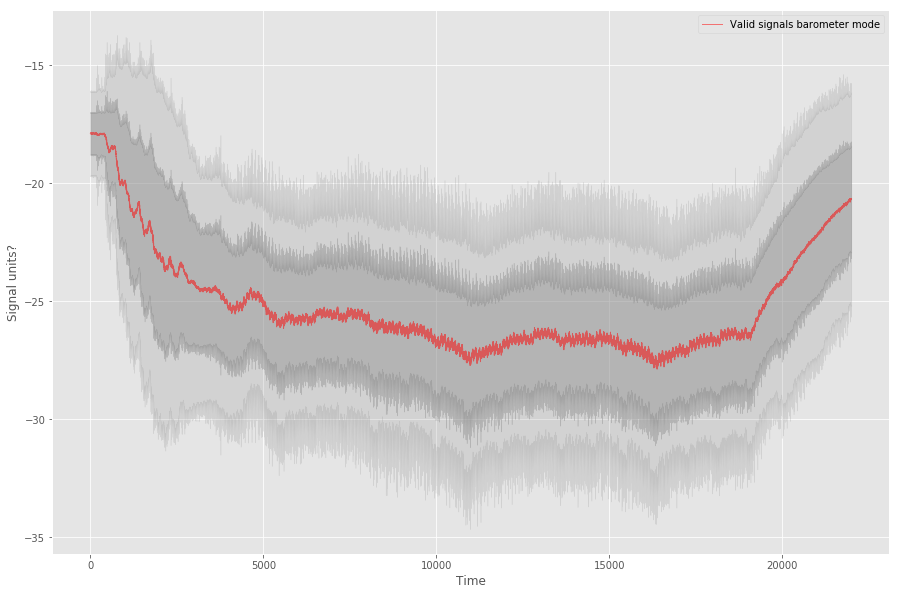

In [4]:
valid_bar, _ = get_signals('../Scripts/Applications/Data_processing/MPL_VALID_SWEEP_bar-active')
plot_signals(valid_bar, 'Valid signals barometer mode')

In [5]:
div = 100

def downsample(s, R):
    s = s.reshape(-1, R)
    return s.reshape(-1, R).mean(axis=1)

def downsample_signals(signals):
    downsampled_signals = np.zeros([signals.shape[0], LENGTH//div])
    
    for i, signal in enumerate(signals):
        downsampled_signals[i] = downsample(signal, div)
        
    return downsampled_signals

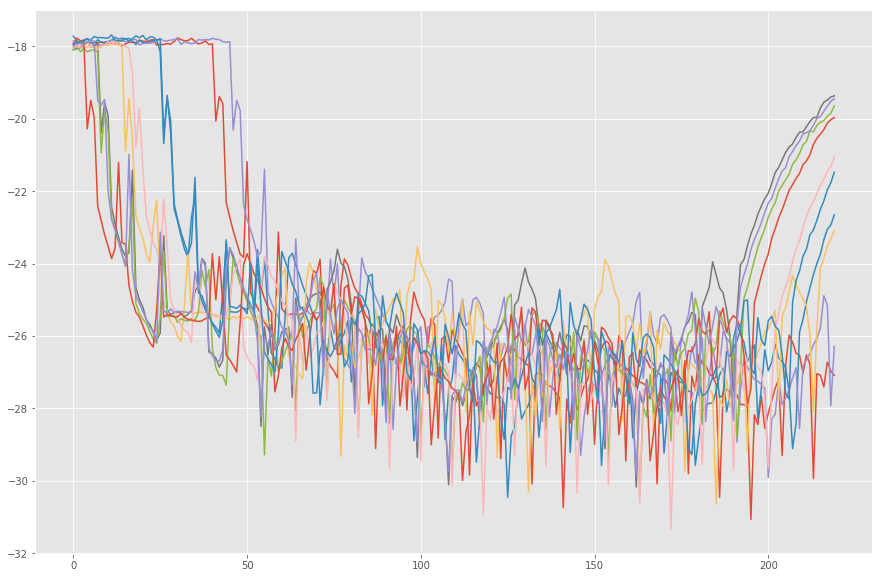

In [6]:
downsampled_signals = downsample_signals(valid_bar)
plot_sig(downsampled_signals)

Signals loaded. Length of a signal is 22000, No. of signals is: 98


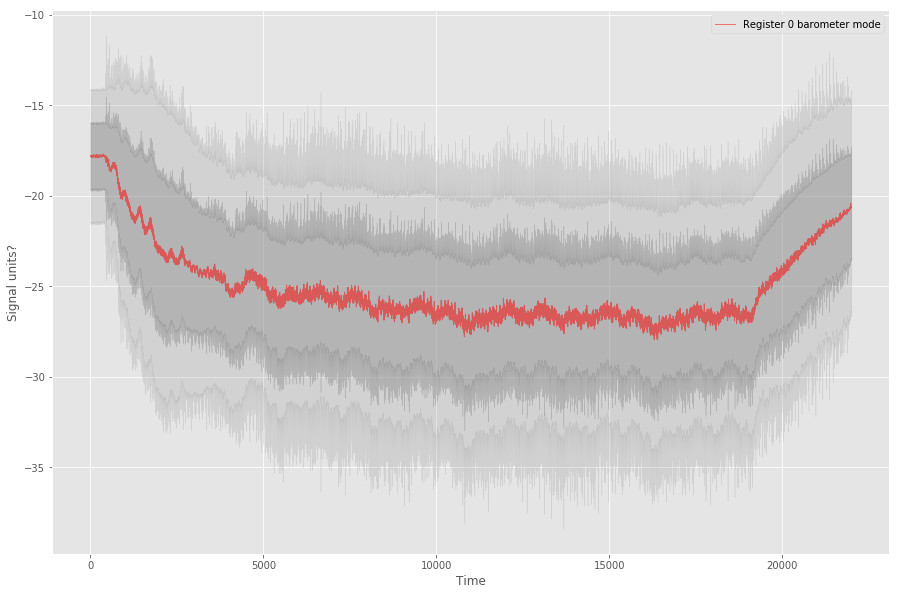

In [7]:
reg0_bar, _ = get_signals('../Scripts/Applications/Data_processing/MPL-REG-0-bar-active')
plot_signals(reg0_bar, 'Register 0 barometer mode')

Signals loaded. Length of a signal is 22000, No. of signals is: 98


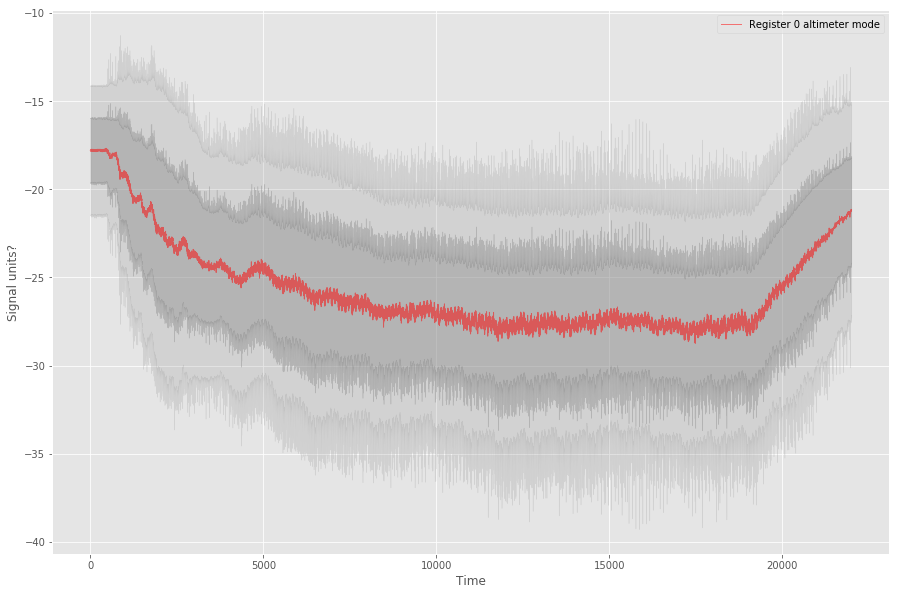

In [8]:
reg0_alt, _ = get_signals('../Scripts/Applications/Data_processing/MPL-REG-0-alt-active')
plot_signals(reg0_alt, 'Register 0 altimeter mode')

Signals loaded. Length of a signal is 22000, No. of signals is: 409


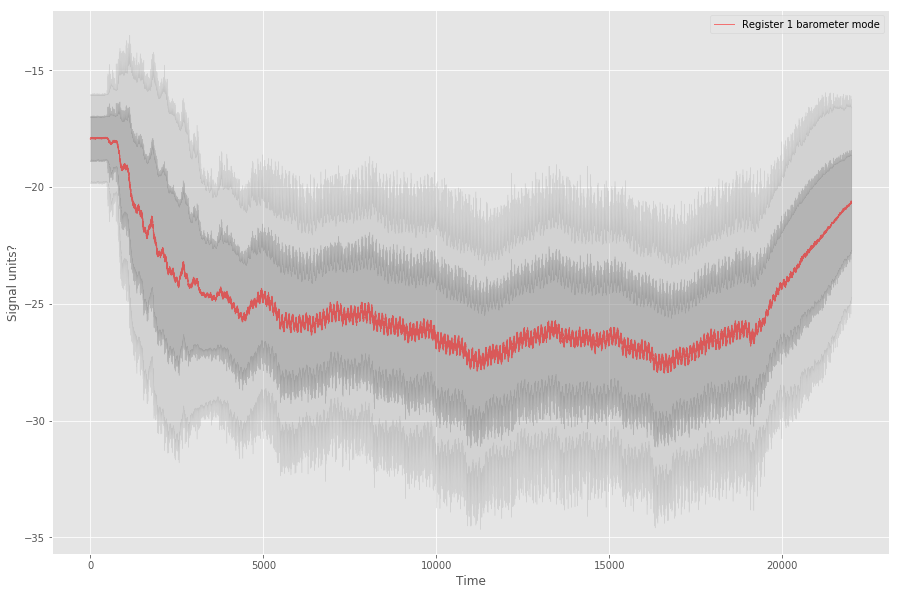

In [9]:
reg1_bar, _ = get_signals('../Scripts/Applications/Data_processing/MPL-REG-1-bar-active')
plot_signals(reg1_bar, 'Register 1 barometer mode')

Signals loaded. Length of a signal is 22000, No. of signals is: 397


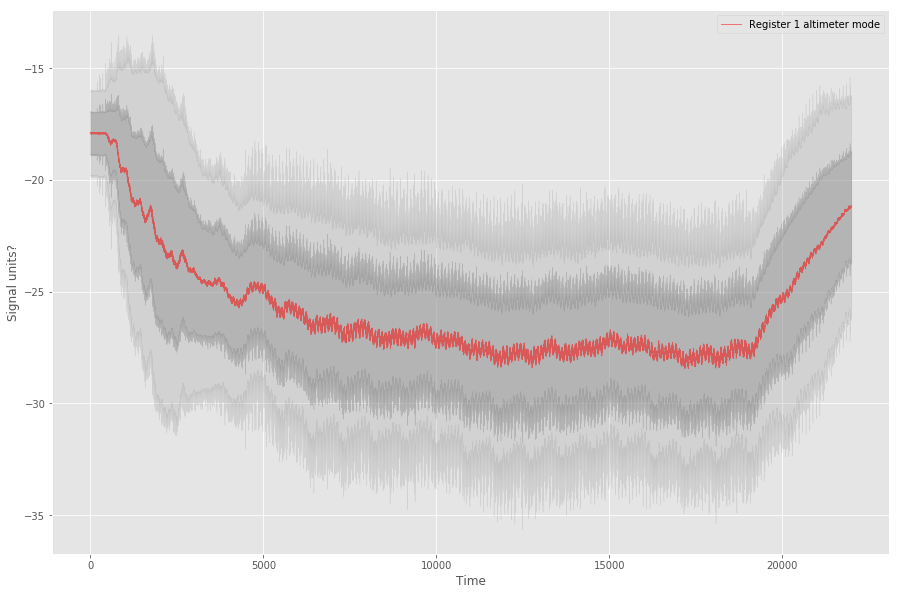

In [10]:
reg1_alt, _ = get_signals('../Scripts/Applications/Data_processing/MPL-REG-1-alt-active')
plot_signals(reg1_alt, 'Register 1 altimeter mode')

In [14]:
reg1_bar_standby, _ = get_signals('../Scripts/Applications/Data_processing/MPL-REG-1-bar-mode')

Signals loaded. Length of a signal is 22000, No. of signals is: 374


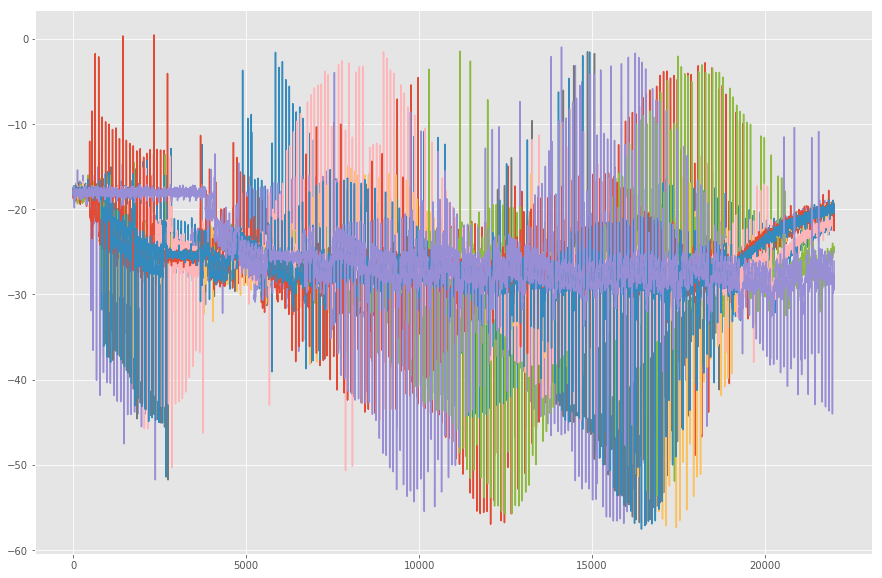

In [11]:
plot_sig(reg1_alt)

In [12]:
from keras.models import Sequential, Model
from keras.layers import Conv1D, Flatten, Dense, Dropout, MaxPooling1D, GlobalAveragePooling1D, Input, UpSampling1D
from keras.utils import to_categorical
from keras import regularizers
import keras

Using TensorFlow backend.


In [21]:
# create train/test split (3/4)

size=200
x = np.concatenate((downsample_signals(reg1_bar[0:size]), downsample_signals(reg1_alt[0:size])),axis=0)
                    #downsample_signals(reg0_bar[0:size]), downsample_signals(reg0_alt[0:size])),axis=0)
x0 = np.concatenate((downsample_signals(reg0_bar[0:size]), downsample_signals(reg0_alt[0:size])),axis=0)

x_ = np.concatenate((downsample_signals(reg1_bar[0:size]), 
                     downsample_signals(reg1_bar_standby[0:size]),
                     downsample_signals(reg1_alt[0:size])),axis=0)

y1 = np.zeros(size)
y2 = np.ones(size)
y3 = np.ones(size)+1
y4 = np.ones(size)+2
#y = to_categorical(np.concatenate((y1,y2,y3,y4)))
y = np.concatenate((y1,y2)).reshape(-1,1)

print(x.shape)
print(y.shape)

dataset = np.concatenate((x,y), axis=1)
np.random.shuffle(dataset)
ind = size//2
training, test = dataset[ind:,:], dataset[:ind,:]
train_x, train_y = training[:,:-y.shape[1]], training[:,-y.shape[1]:]
test_x, test_y = test[:,:-y.shape[1]], test[:,-y.shape[1]:]

seq_length, n_features, n_outputs = train_x.shape[1], 1, y.shape[1]
print("Sequence length is", seq_length)

train_x = train_x.reshape(-1,seq_length, n_features)
test_x = test_x.reshape(-1, seq_length, n_features)
print(train_x.shape)
print(train_y.shape)


(400, 220)
(400, 1)
Sequence length is 220
(300, 220, 1)
(300, 1)


In [276]:
verbose, epochs, batch_size = 1, 10, 5

model = Sequential((
    # The first conv layer learns `nb_filter` filters (aka kernels), each of size ``(filter_length, nb_input_series)``.
    # Its output will have shape (None, window_size - filter_length + 1, nb_filter), i.e., for each position in
    # the input timeseries, the activation of each filter at that position.
    Conv1D(filters=16, kernel_size=16, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='zeros', input_shape=(seq_length, n_features)),
    MaxPooling1D(),
    Conv1D(filters=16, kernel_size=16, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='zeros'),
    MaxPooling1D(),
    Flatten(),
    Dense(n_outputs, activation='sigmoid'),     # For binary classification, change the activation to 'sigmoid'
                                                # For others, use 'softmax'
))
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# for binary classification use binary_crossentropy
# for multiple use categorical_crossentropy

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_142 (Conv1D)          (None, 205, 16)           272       
_________________________________________________________________
max_pooling1d_109 (MaxPoolin (None, 102, 16)           0         
_________________________________________________________________
conv1d_143 (Conv1D)          (None, 87, 16)            4112      
_________________________________________________________________
max_pooling1d_110 (MaxPoolin (None, 43, 16)            0         
_________________________________________________________________
flatten_71 (Flatten)         (None, 688)               0         
_________________________________________________________________
dense_103 (Dense)            (None, 1)                 689       
Total params: 5,073
Trainable params: 5,073
Non-trainable params: 0
_________________________________________________________________


In [277]:
model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)

Epoch 1/10
300/300 [==============================] - 2s 8ms/step - loss: 0.8170 - acc: 0.5433
Epoch 2/10
300/300 [==============================] - 0s 999us/step - loss: 0.6726 - acc: 0.5867
Epoch 3/10
300/300 [==============================] - 0s 1ms/step - loss: 0.6582 - acc: 0.6567
Epoch 4/10
300/300 [==============================] - 0s 980us/step - loss: 0.6444 - acc: 0.7733
Epoch 5/10
300/300 [==============================] - 0s 986us/step - loss: 0.6258 - acc: 0.7667
Epoch 6/10
300/300 [==============================] - 0s 1ms/step - loss: 0.5862 - acc: 0.8300
Epoch 7/10
300/300 [==============================] - 0s 1ms/step - loss: 0.5573 - acc: 0.7900
Epoch 8/10
300/300 [==============================] - 0s 1ms/step - loss: 0.4972 - acc: 0.8167
Epoch 9/10
300/300 [==============================] - 0s 1ms/step - loss: 0.4457 - acc: 0.8267
Epoch 10/10
300/300 [==============================] - 0s 1ms/step - loss: 0.4389 - acc: 0.8200


In [269]:
print(test_y[0:10])
print(model.predict(test_x[0:10]))

[[1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]]
[[0.7203733 ]
 [0.40071458]
 [0.69909894]
 [0.701397  ]
 [0.657077  ]
 [0.6252958 ]
 [0.56024194]
 [0.7897155 ]
 [0.3520887 ]
 [0.36985755]]


In [278]:
_, accuracy = model.evaluate(train_x, train_y, batch_size=batch_size, verbose=0)
print(accuracy)
# evaluate model
_, accuracy = model.evaluate(test_x, test_y, batch_size=batch_size, verbose=0)
print(accuracy)

0.8600000073512395
0.82000000923872


In [17]:
def dtw(x, y):
    distance, path = fastdtw(x, y, dist=1)
    return distance

In [16]:
reg1_bar_downsampled = downsample_signals(reg1_bar)
reg1_alt_downsampled = downsample_signals(reg1_alt)
print("REG 1")
for i in range(1,5):
    print(dtw(reg1_bar_downsampled[10], reg1_bar_downsampled[i]))
print("--------------")
for i in range(1,5):
    print(dtw(reg1_bar_downsampled[10], reg1_alt_downsampled[i]))
print("=======REG 0=======")
reg0_bar_downsampled = downsample_signals(reg0_bar)
reg0_alt_downsampled = downsample_signals(reg0_alt)

for i in range(1,5):
    print(dtw(reg0_bar_downsampled[10], reg0_bar_downsampled[i]))
print("--------------")
for i in range(1,5):
    print(dtw(reg0_bar_downsampled[10], reg0_alt_downsampled[i]))
print("======= ALL VALID ========")
valid_downsampled = downsample_signals(valid_bar)

for i in range(1,10):
    print(dtw(valid_downsampled[0], valid_downsampled[i]))

REG 1
113.69189453107603
67.73559570357801
70.75500488161697
78.103881836431
--------------
133.8430175780071
146.85913086012695
137.47619629007502
136.89575195401605
=======REG 0=======
92.43359375088193
55.54345703082794
104.06713867198408
94.35473632832782
--------------
111.54687500033786
131.71411132809104
145.24853515698192
177.3574218745809
======= ALL VALID ========
87.94592285140016
88.78918456975325
245.21582031088585
130.29187011701526
220.38891601445408
101.79711913879723
206.11999511693
183.06750488148015
227.74328613290493


/home/johnny/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  


In [22]:
from sklearn.cluster import DBSCAN
clus= DBSCAN(eps=60, min_samples=3, metric=dtw).fit(x_)

/home/johnny/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  
/home/johnny/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  


In [23]:
unique, counts = np.unique(clus.labels_, return_counts=True)
dict(zip(unique, counts))

{-1: 10, 0: 192, 1: 200, 2: 198}

Cluster 0 number of entries 192


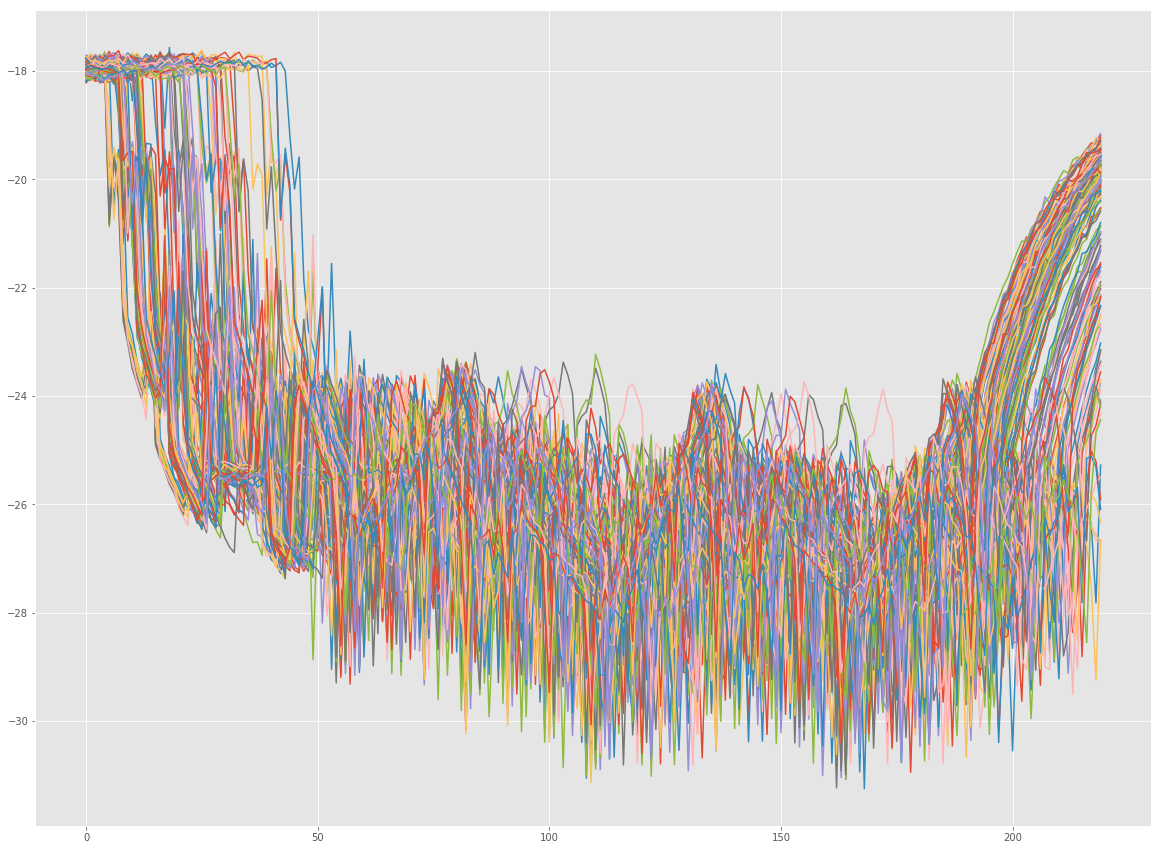

Cluster -1 number of entries 10


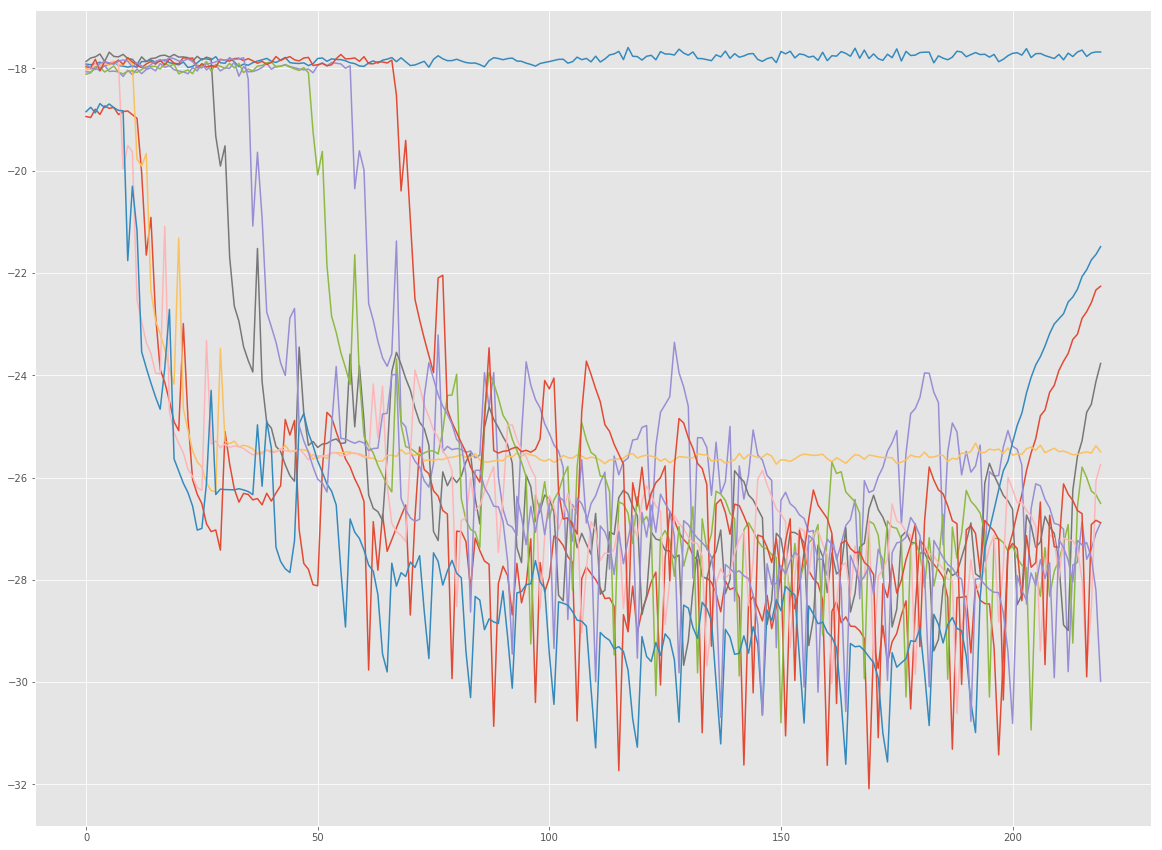

Cluster 1 number of entries 200


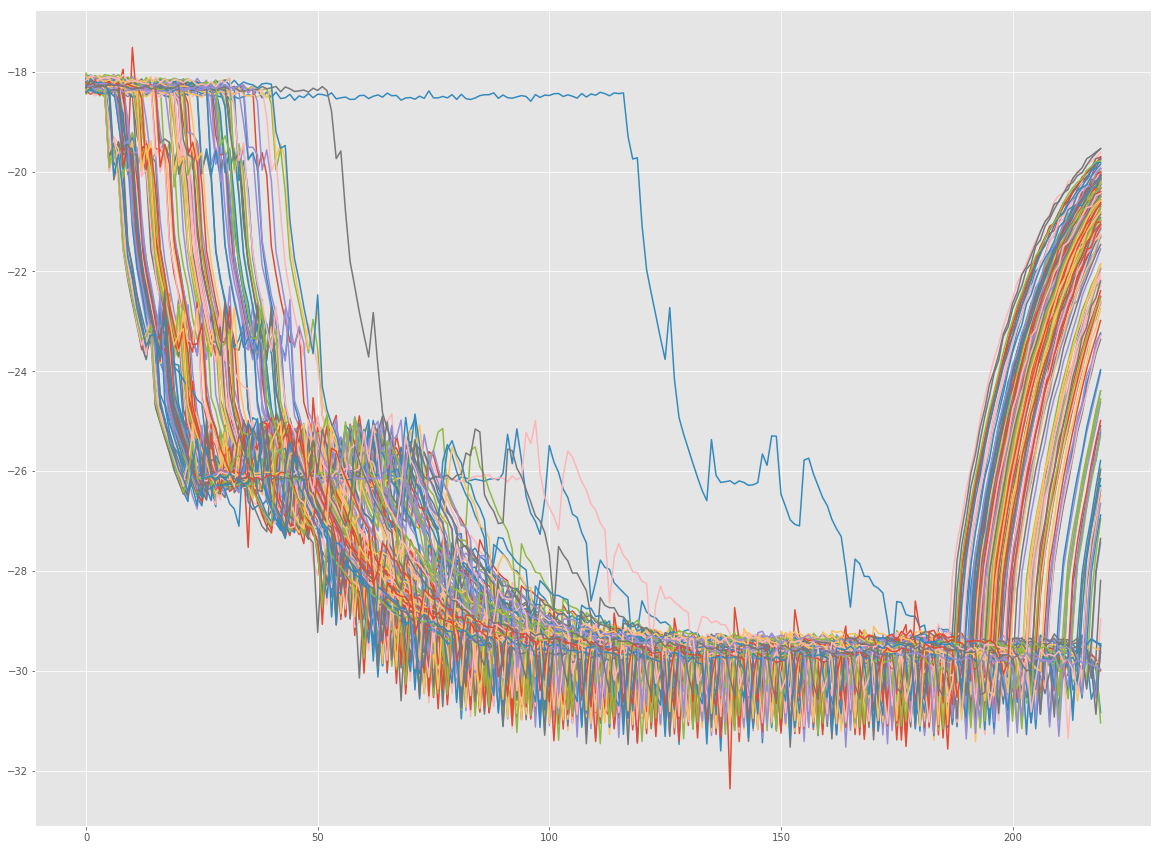

Cluster 2 number of entries 198


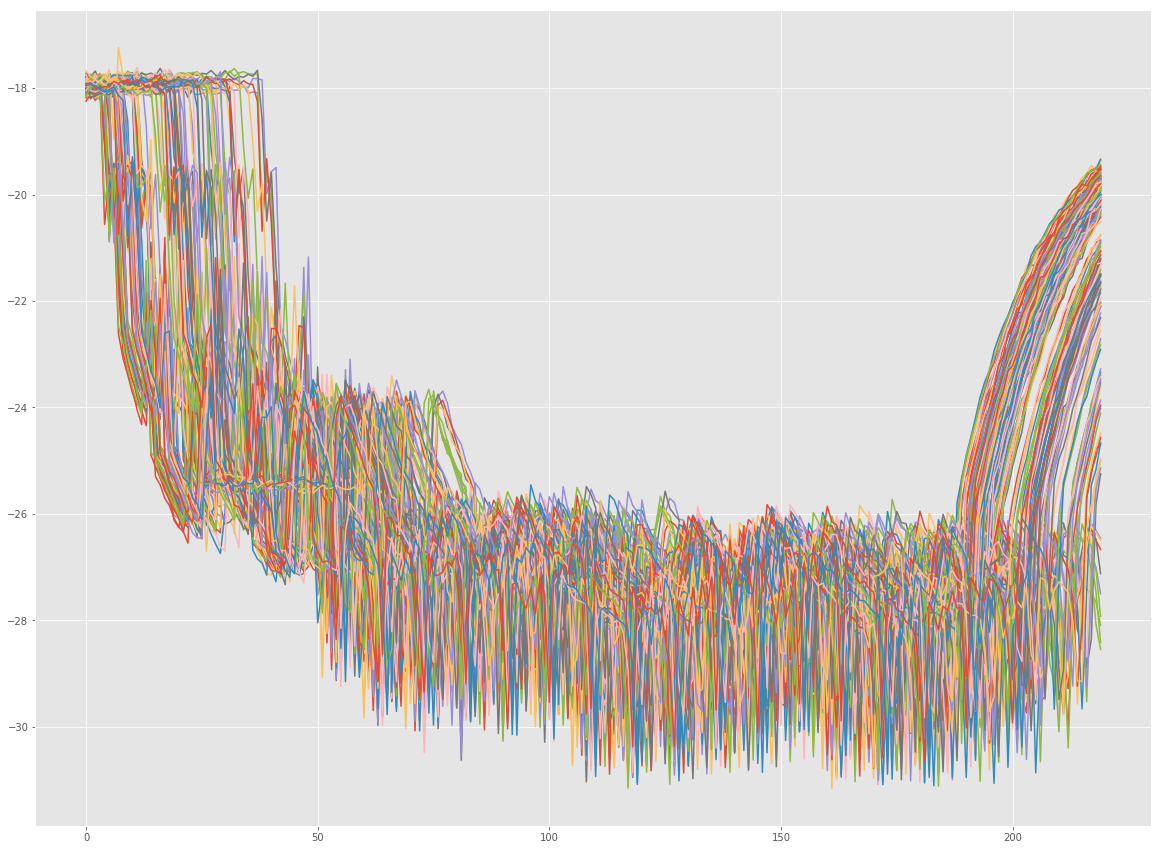

In [24]:
def plot_clusters(data, labels):
    import pandas as pd

    timeSeries = pd.DataFrame(data = data)

    # check the results
    s = pd.Series(labels)
    clusters = s.unique()

    for c in clusters:
        cluster_indices = s[s==c].index
        print("Cluster %d number of entries %d" % (c, len(cluster_indices)))
        timeSeries.T.iloc[:,cluster_indices].plot(figsize=(20,15), legend=False)
        plt.show()
        
plot_clusters(x_, clus.labels_)

In [303]:
valid_downsampled.shape

(459, 220)

In [305]:
y = np.concatenate((np.array(range(1,46)), np.array(list(range(0,46))*9)))
y = to_categorical(y)
y

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [308]:
dataset = np.concatenate((valid_downsampled,y), axis=1)
np.random.shuffle(dataset)
ind = 45
training, test = dataset[ind:,:], dataset[:ind,:]
print(training.shape)
train_x, train_y = training[:,:-y.shape[1]], training[:,-y.shape[1]:]
test_x, test_y = test[:,:-y.shape[1]], test[:,-y.shape[1]:]

seq_length, n_features, n_outputs = train_x.shape[1], 1, y.shape[1]
print("Sequence length is", seq_length)

train_x = train_x.reshape(-1,seq_length, n_features)
test_x = test_x.reshape(-1, seq_length, n_features)
print(train_x.shape)
print(train_y.shape)


(414, 266)
Sequence length is 220
(414, 220, 1)
(414, 46)


31
31
21


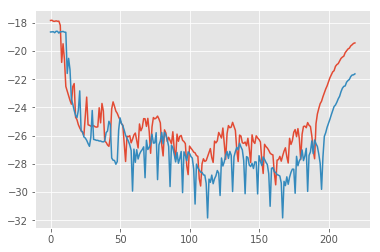

In [351]:
print(np.argmax(train_y[3]))
#plt.plot(train_x[3])
plt.plot(train_x[111])
plt.plot(train_x[1])
print(np.argmax(train_y[111]))
print(np.argmax(model.predict(train_x[111:112])))

In [356]:
verbose, epochs, batch_size = 1, 100, 5

model = Sequential((
    # The first conv layer learns `nb_filter` filters (aka kernels), each of size ``(filter_length, nb_input_series)``.
    # Its output will have shape (None, window_size - filter_length + 1, nb_filter), i.e., for each position in
    # the input timeseries, the activation of each filter at that position.
    Conv1D(filters=128, kernel_size=16, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='zeros', input_shape=(seq_length, n_features)),
    MaxPooling1D(),
    Conv1D(filters=128, kernel_size=16, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='zeros'),
    MaxPooling1D(),
    Flatten(),
    Dense(100, activation='sigmoid'),
    Dense(n_outputs, activation='sigmoid'),     # For binary classification, change the activation to 'sigmoid'
                                                # For others, use 'softmax'
))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
# for binary classification use binary_crossentropy
# for multiple use categorical_crossentropy

model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_154 (Conv1D)          (None, 205, 128)          2176      
_________________________________________________________________
max_pooling1d_121 (MaxPoolin (None, 102, 128)          0         
_________________________________________________________________
conv1d_155 (Conv1D)          (None, 87, 128)           262272    
_________________________________________________________________
max_pooling1d_122 (MaxPoolin (None, 43, 128)           0         
_________________________________________________________________
flatten_77 (Flatten)         (None, 5504)              0         
_________________________________________________________________
dense_109 (Dense)            (None, 100)               550500    
_________________________________________________________________
dense_110 (Dense)            (None, 46)                4646      
Total para

In [311]:
_, accuracy = model.evaluate(train_x, train_y, batch_size=batch_size, verbose=0)
print(accuracy)
# evaluate model
_, accuracy = model.evaluate(test_x, test_y, batch_size=batch_size, verbose=0)
print(accuracy)

0.9783133844246611
0.97826087474823


In [319]:
print(test_y[5:6])
print(model.predict(test_x[5:6]))

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0.01832277 0.02003304 0.05363771 0.02305649 0.01951393 0.01554045
  0.04187822 0.02240626 0.0305393  0.0225422  0.03353627 0.02432781
  0.02791031 0.02032431 0.03297577 0.0250247  0.02328983 0.04568806
  0.01990945 0.04593911 0.02508871 0.03876437 0.01186804 0.01508479
  0.03493779 0.01651411 0.02207374 0.01858918 0.01509298 0.02183272
  0.01198152 0.01810688 0.02757888 0.03412493 0.04474794 0.0490159
  0.01931303 0.01537295 0.02158632 0.02867036 0.0359881  0.02095871
  0.04494948 0.02204538 0.04852251 0.0340823 ]]
